In [15]:
import warnings
from pathlib import Path

import numpy as np
from sklearn.model_selection import KFold

from gfos.data.utils import load_layout
from gfos.data.dataset import sample_configs
from gfos.utils.misc import seed_everything

SEED = 42
LAYOUT_DIR = r"H:\data\gfos\predict-ai-model-runtime\npz_all\npz\layout"
# LAYOUT_DIR = "../../input/npz_all/npz/layout/"
SOURCE = "xla"
SEARCH = "random"
MAX_CONFIGS = 10240
NUM_FOLDS = 5
OUTPUT_ROOT = "../../data/indices_full"


data_root = Path(OUTPUT_ROOT)
data_root.mkdir(exist_ok=True)

seed_everything(SEED)
warnings.filterwarnings("ignore")

In [16]:
files = load_layout(LAYOUT_DIR, model_type=SOURCE, compile_type=SEARCH)
train_val_file = files["train"] + files["valid"]
cs = [len(np.load(file)["config_runtime"]) for file in train_val_file]

print(f"Fewest configs: {min(cs)}")
print(f"Most configs: {max(cs)}")

Fewest configs: 20
Most configs: 100040


Use original split

In [17]:
folds = [(files["train"], files["valid"])] * NUM_FOLDS

Split training and valid (No use)

In [18]:
# folds = []
# for train_idx, valid_idx in KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED).split(train_val_file):
#     folds.append(
#         (
#             [train_val_file[idx] for idx in train_idx],
#             [train_val_file[idx] for idx in valid_idx],
#         )
#     )
# print("File in each fold:")

# for train_files, val_files in folds:
#     print(f"Train: {len(train_files)}, Val: {len(val_files)}")

Sample indices in training files

In [19]:
for fold, (train_files, valid_files) in enumerate(folds):
    fold_dir = data_root / f"{SOURCE}_{SEARCH}" / f"{fold}"
    train_dir = fold_dir / "train"
    train_dir.mkdir(exist_ok=True, parents=True)
    valid_dir = fold_dir / "valid"
    valid_dir.mkdir(exist_ok=True, parents=True)

    for file in train_files:
        model_id = Path(file).stem
        npz = np.load(file)
        config_runtime = npz["config_runtime"]
        
        c = len(config_runtime)
        mc = min(MAX_CONFIGS, c) if MAX_CONFIGS > 0 else c
        third = MAX_CONFIGS // 3

        sorted_indices = np.argsort(config_runtime)
        
        if third * NUM_FOLDS > c or 2 * (third * NUM_FOLDS) > c:
            third = mc // 3
            keep_indices = np.concatenate(
                [
                    sorted_indices[:third],  # Good configs.
                    sorted_indices[-third:],  # Bad configs.
                    np.random.choice(
                        sorted_indices[third:-third],
                        mc - 2 * third,
                    ),
                ]
            )
        else:
            keep_indices = np.concatenate(
                [
                    np.random.choice(
                        sorted_indices[:third * NUM_FOLDS],
                        third,
                    ), # Good configs.
                    np.random.choice(
                        sorted_indices[-third * NUM_FOLDS:],
                        third,
                    ), # Bad configs.
                    np.random.choice(
                        sorted_indices[third * NUM_FOLDS: -third * NUM_FOLDS],
                        mc - 2 * third,
                    ),
                ]
            )

        np.save(train_dir / f"{model_id}.npy", keep_indices)
    
    valid_for_train = {}
    for file in valid_files:
        model_id = Path(file).stem
        npz = np.load(file)
        config_runtime = npz["config_runtime"]
        
        c = len(config_runtime)
        mc = min(MAX_CONFIGS, c) if MAX_CONFIGS > 0 else c
        third = MAX_CONFIGS // 3

        sorted_indices = np.argsort(config_runtime)
        
        if third * NUM_FOLDS > c or 2 * (third * NUM_FOLDS) > c:
            third = mc // 3
            keep_indices = np.concatenate(
                [
                    sorted_indices[:third],  # Good configs.
                    sorted_indices[-third:],  # Bad configs.
                    np.random.choice(
                        sorted_indices[third:-third],
                        mc - 2 * third,
                    ),
                ]
            )
        else:
            keep_indices = np.concatenate(
                [
                    np.random.choice(
                        sorted_indices[:third * NUM_FOLDS],
                        third,
                    ), # Good configs.
                    np.random.choice(
                        sorted_indices[-third * NUM_FOLDS:],
                        third,
                    ), # Bad configs.
                    np.random.choice(
                        sorted_indices[third * NUM_FOLDS: -third * NUM_FOLDS],
                        mc - 2 * third,
                    ),
                ]
            )

        np.save(train_dir / f"{model_id}.npy", keep_indices)
        valid_for_train[model_id] = keep_indices

    for file in valid_files:
        model_id = Path(file).stem
        all_indices = np.arange(len(np.load(file)["config_runtime"]))
        valid_idx = np.setdiff1d(all_indices, valid_for_train[model_id])
        np.save(valid_dir / f"{model_id}.npy", valid_idx)


In [26]:
for file in valid_files:
    model_id = Path(file).stem
    data = np.load(file)
    runtime = data["config_runtime"]
    print(f"{model_id}: {len(runtime)}")

bert_pretraining.4x4.fp16: 19040
inception_v3_batch_128_train: 4688
mlperf_bert_batch_24_2x2: 5288
resnet50.4x4.fp16: 5704
resnet_v1_50_official_batch_128_bf16: 7248
tf2_bert_pretrain_dynamic_batch_size: 17360
unet_3d.4x4.bf16: 481


In [24]:
from pathlib import Path

valid_model = []
for file in Path("../../data/indices_full/xla_random/0/valid/").iterdir():
    print(file.stem, len(np.load(file)))
    valid_model.append(file.stem)

for file in Path("../../data/indices_full/xla_random/0/train/").iterdir():
    if file.stem not in valid_model:
        continue
    print(file.stem, len(np.load(file)))


bert_pretraining.4x4.fp16 9254
inception_v3_batch_128_train 552
mlperf_bert_batch_24_2x2 653
resnet50.4x4.fp16 681
resnet_v1_50_official_batch_128_bf16 915
tf2_bert_pretrain_dynamic_batch_size 7608
unet_3d.4x4.bf16 62
bert_pretraining.4x4.fp16 10240
inception_v3_batch_128_train 4688
mlperf_bert_batch_24_2x2 5288
resnet50.4x4.fp16 5704
resnet_v1_50_official_batch_128_bf16 7248
tf2_bert_pretrain_dynamic_batch_size 10240
unet_3d.4x4.bf16 481


unet3d has 1159 configs.
brax_es has 100040 configs.


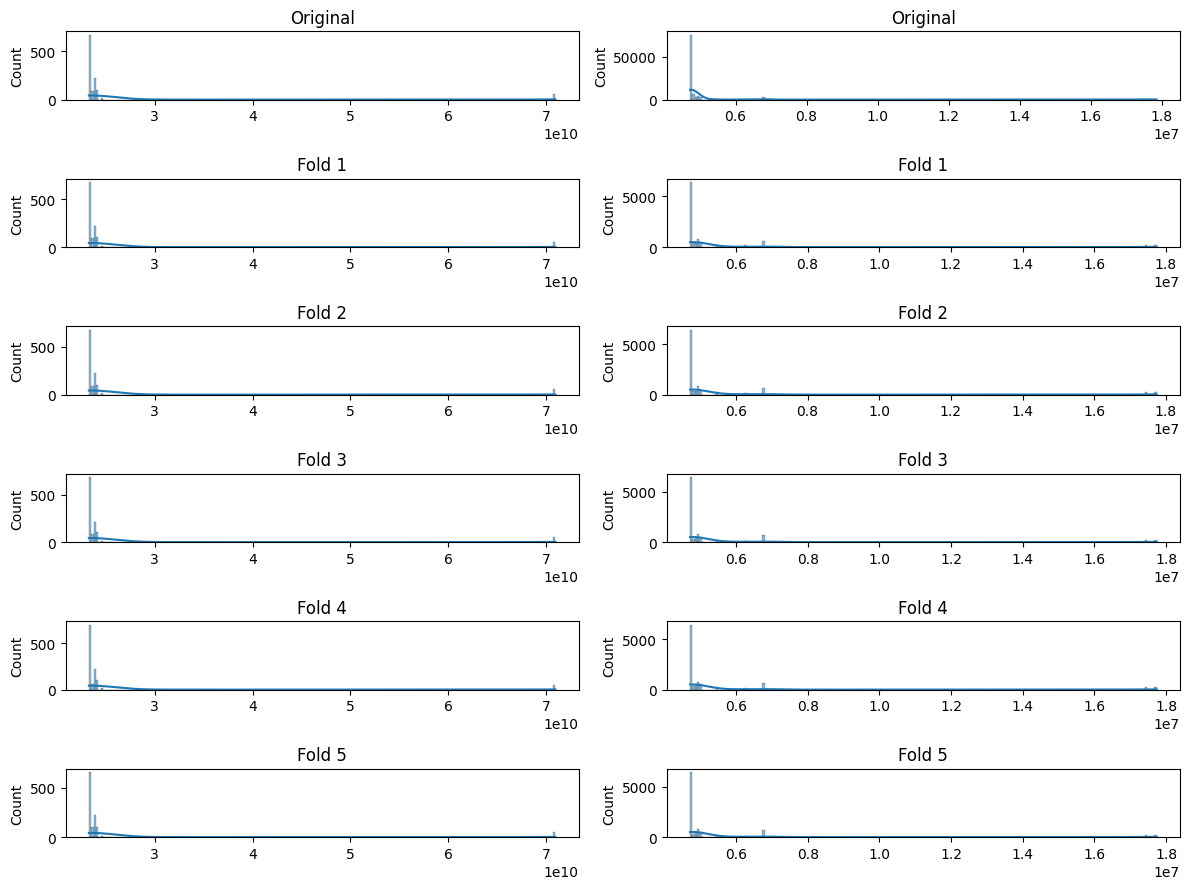

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


# Original hist
train_files = files["train"]
cs = [len(np.load(file)["config_runtime"]) for file in train_files]

axes = plt.subplots(NUM_FOLDS + 1, 2, figsize=(12, 9))[1].flatten()

fewest_configs_idx = np.argmin(cs)
model = Path(train_files[fewest_configs_idx]).stem
print(f"{model} has {cs[fewest_configs_idx]} configs.")
indices_folds = [np.load(data_root / f"{SOURCE}_{SEARCH}" / f"{i}" / "train" /  f"{model}.npy") for i in range(NUM_FOLDS)]
runtime = np.load(train_files[fewest_configs_idx])["config_runtime"]
sns.histplot(runtime, kde=True, bins=200, ax=axes[0])
axes[0].set_title("Original")
for i in range(NUM_FOLDS):
    runtime_fold = runtime[indices_folds[i]]
    sns.histplot(runtime_fold, kde=True, ax=axes[2*(i+1)], bins=200)
    axes[2*(i+1)].set_title(f"Fold {i+1}")


most_configs_idx = np.argmax(cs)
model = Path(train_files[most_configs_idx]).stem
print(f"{model} has {cs[most_configs_idx]} configs.")
indices_folds = [np.load(data_root / f"{SOURCE}_{SEARCH}" / f"{i}" / "train" / f"{model}.npy") for i in range(NUM_FOLDS)]
runtime = np.load(train_files[most_configs_idx])["config_runtime"]
sns.histplot(runtime, kde=True, bins=200, ax=axes[1])
axes[1].set_title("Original")
for i in range(NUM_FOLDS):
    runtime_fold = runtime[indices_folds[i]]
    sns.histplot(runtime_fold, kde=True, ax=axes[2*i+3], bins=200)
    axes[2*i+3].set_title(f"Fold {i+1}")

plt.tight_layout()

## Method from Kawashima-san

In [3]:
max_configs = 10240
NUM_FOLDS = 10

for fold in range(NUM_FOLDS):
    fold_dir = data_root / f"{SOURCE}_{SEARCH}" / f"{fold}"
    train_dir = fold_dir / "train"
    valid_dir = fold_dir / "valid"
    train_dir.mkdir(exist_ok=True, parents=True)
    valid_dir.mkdir(exist_ok=True, parents=True)

    for file in files["train"]:
        data = np.load(file)
        
        config_runtime = data["config_runtime"]
        c = len(config_runtime)

        mc = min(max_configs, c) if max_configs > 0 else c

        if mc == c:
            c_index_list = [x for x in range(c)]
        else:
            # If max_k_fold=2, fold=0
            # sorted_config_runtime = [1,2,3,4,5,6,7,9,8] -> c_index_list = [0, 2, 4, 6, 7]
            # e.g., len(c)=1000, max_configs=500, max_k_fold=10 -> len(c_index_list)=500
            k_fold = min((c // mc) + 1, NUM_FOLDS)
            fold = fold % k_fold
            sorted_indices = np.argsort(config_runtime)
            fold_indices = [x for x in range(c) if x % k_fold == fold]
            c_index_list = sorted_indices[fold_indices]
            
        np.save(
            train_dir / f"{Path(file).stem}.npy",
            c_index_list,
        )
    
    for file in files["valid"]:
        keep_indices = np.arange(len(np.load(file)["config_runtime"]))
        np.save(valid_dir / f"{Path(file).stem}.npy", keep_indices)


unet3d has 1159 configs.
brax_es has 100040 configs.


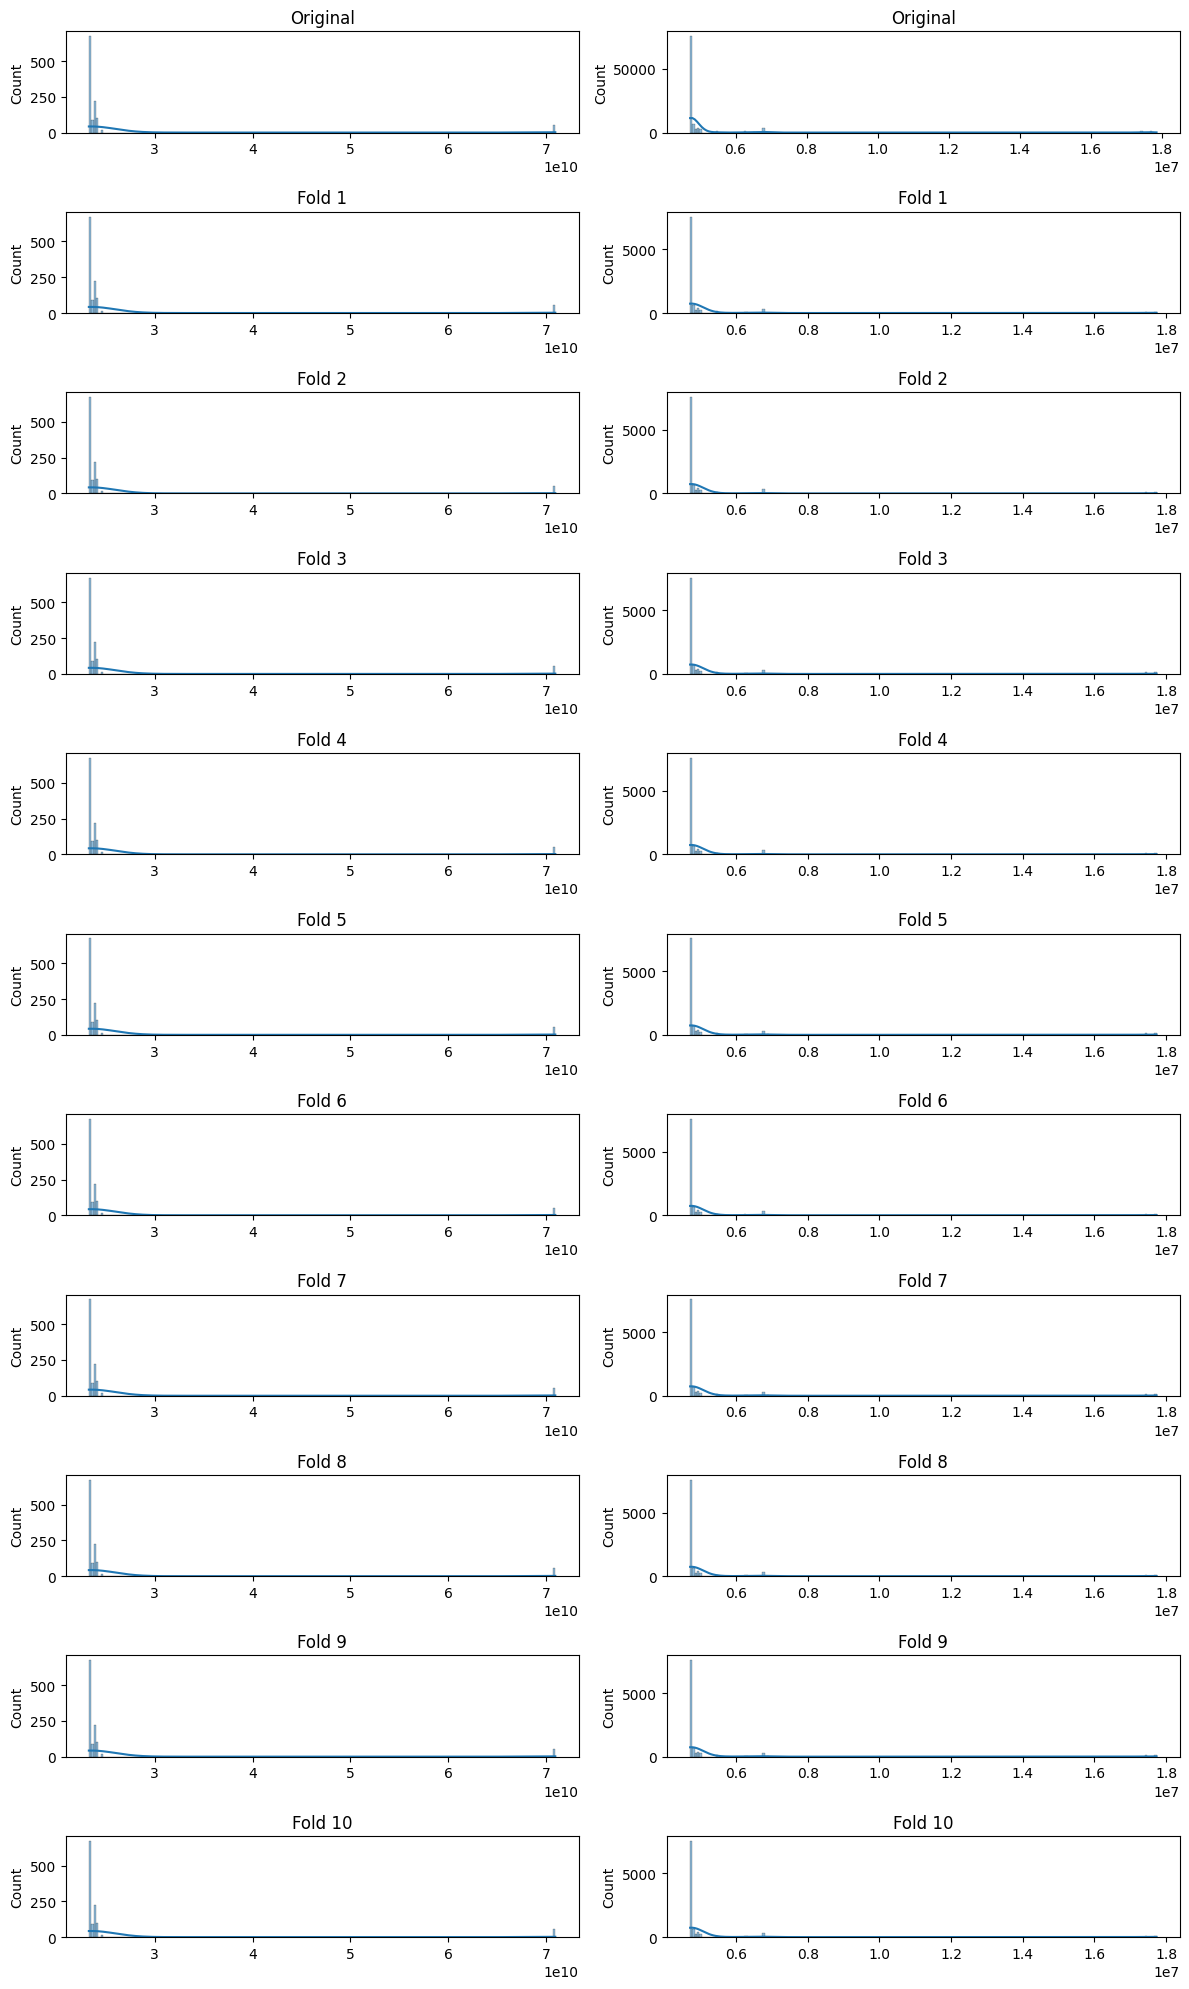

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


# Original hist
train_files = files["train"]
cs = [len(np.load(file)["config_runtime"]) for file in train_files]

axes = plt.subplots(NUM_FOLDS + 1, 2, figsize=(12, 20))[1].flatten()

fewest_configs_idx = np.argmin(cs)
model = Path(train_files[fewest_configs_idx]).stem
print(f"{model} has {cs[fewest_configs_idx]} configs.")
indices_folds = [np.load(data_root / f"{SOURCE}_{SEARCH}" / f"{i}" / "train" /  f"{model}.npy") for i in range(NUM_FOLDS)]
runtime = np.load(train_files[fewest_configs_idx])["config_runtime"]
sns.histplot(runtime, kde=True, bins=200, ax=axes[0])
axes[0].set_title("Original")
for i in range(NUM_FOLDS):
    runtime_fold = runtime[indices_folds[i]]
    sns.histplot(runtime_fold, kde=True, ax=axes[2*(i+1)], bins=200)
    axes[2*(i+1)].set_title(f"Fold {i+1}")


most_configs_idx = np.argmax(cs)
model = Path(train_files[most_configs_idx]).stem
print(f"{model} has {cs[most_configs_idx]} configs.")
indices_folds = [np.load(data_root / f"{SOURCE}_{SEARCH}" / f"{i}" / "train" / f"{model}.npy") for i in range(NUM_FOLDS)]
runtime = np.load(train_files[most_configs_idx])["config_runtime"]
sns.histplot(runtime, kde=True, bins=200, ax=axes[1])
axes[1].set_title("Original")
for i in range(NUM_FOLDS):
    runtime_fold = runtime[indices_folds[i]]
    sns.histplot(runtime_fold, kde=True, ax=axes[2*i+3], bins=200)
    axes[2*i+3].set_title(f"Fold {i+1}")

plt.tight_layout()